In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_recall_curve, 
    precision_score, recall_score, f1_score, confusion_matrix, roc_curve, average_precision_score
)

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator
from tqdm import tqdm


import json
import yaml
import random
import wandb
import ast
import optuna

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.1.0) or chardet (5.2.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data Load

In [2]:
def load_ptb_data():
    # PTB-XL 데이터셋 로드 및 전처리
    df_ptb = pd.read_csv('./ptb_xl_data/ptbxl_database.csv', index_col='ecg_id')
    df_ptb.scp_codes = df_ptb.scp_codes.apply(lambda x: ast.literal_eval(x))
    df_ptb.scp_codes = df_ptb.scp_codes.apply(lambda x: list(x.keys()))
    df_ptb['label'] = df_ptb.scp_codes.apply(lambda arr: 1 if 'AFIB' in arr else 0)
    # 총 21799개 중 AFIB 라벨이 있는 샘플은 1514개로 6.95%에 해당, 샘플 불균형 존재

    labels = df_ptb['label'].values
    lead1_signals = np.load('./custom_file/annie_ptb_xl_lead1.npy')


    # 데이터 정규화 (전체)
    lead1_signals_normalized = (lead1_signals - lead1_signals.mean()) / (lead1_signals.std()+1e-7)

    # 데이터셋을 텐서로 변환
    X = torch.Tensor(lead1_signals_normalized)
    y = torch.Tensor(labels).long()

    # 데이터 분할 (훈련:검증:테스트 = 8:1:1)
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

    # 채널 수를 1로 추가
    X_train = X_train.unsqueeze(1)
    X_val = X_val.unsqueeze(1)
    X_test = X_test.unsqueeze(1)

    return X_train, X_val, X_test, y_train, y_val, y_test



def create_dataloaders(batch_size=64):
    # DataLoader 생성, batch_size를 변경하려면 함수 호출 시 파라미터 변경
    X_train, X_val, X_test, y_train, y_val, y_test = load_ptb_data()

    # DataLoader 생성
    train_data = TensorDataset(X_train, y_train)
    val_data = TensorDataset(X_val, y_val)
    test_data = TensorDataset(X_test, y_test)

    train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
    val_loader = DataLoader(val_data, batch_size=batch_size)
    test_loader = DataLoader(test_data, batch_size=batch_size)

    return train_loader, val_loader, test_loader



def load_sph_data(batch_size=64):
    # SPH 데이터 로드 및 전처리
    df_sph = pd.read_csv("./sph_data/metadata.csv", index_col='ECG_ID')
    # 'AHA_Code' 컬럼의 각 값에 대해 '50'이 포함되어 있는지 확인하고, 'label' 컬럼 생성
    def check_contains_50(code):
        numbers = code.replace(' ', '').replace('+', ';').split(';')
        return '50' in numbers

    df_sph['label'] = df_sph['AHA_Code'].apply(check_contains_50).astype(int)
    
    sph_labels = df_sph['label'].values

    sph_signals = np.load('./custom_file/annie_sph_lead1.npy')
    sph_signals_float = sph_signals.astype(np.float32)
    mean = np.mean(sph_signals_float)
    std = np.std(sph_signals_float)
    sph_signals_normalized = (sph_signals_float - mean) / (std + 1e-7)


    # 데이터 정규화 및 텐서 변환
    X_sph = torch.Tensor(sph_signals_normalized)
    y_sph = torch.Tensor(df_sph['label'].values).long()

    X_sph = X_sph.unsqueeze(1)

    sph_data = TensorDataset(X_sph, y_sph)
    sph_loader = DataLoader(sph_data, batch_size=batch_size)

    return sph_loader



# 1D CNN Modeling

In [3]:
# SimpleCNN

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 32, kernel_size=5, stride=2) 
        self.pool = nn.MaxPool1d(kernel_size=5, stride=1) 
        self.conv2 = nn.Conv1d(32, 64, kernel_size=5) 
        self.fc1 = nn.Linear(64 * 2486, 1000) 
        self.fc2 = nn.Linear(1000, 500)
        self.fc3 = nn.Linear(500, 1)

    def forward(self, x):
        x = self.pool(nn.functional.leaky_relu(self.conv1(x)))
        x = self.pool(nn.functional.leaky_relu(self.conv2(x)))
        x = x.view(-1, 64 * 2486)
        x = nn.functional.leaky_relu(self.fc1(x))
        x = nn.functional.leaky_relu(self.fc2(x))
        x = self.fc3(x)
        return x



# 충원님 코드

class Custom1DCNN(nn.Module):
    def __init__(self):
        super(Custom1DCNN, self).__init__()

        # Convolutional Blocks
        self.conv1 = nn.Conv1d(1, 32, kernel_size=5)
        self.bn1 = nn.BatchNorm1d(32)
        self.relu = nn.ReLU()
        self.maxpool1 = nn.MaxPool1d(2)

        self.conv2 = nn.Conv1d(32, 32, kernel_size=5)
        self.maxpool2 = nn.MaxPool1d(2)

        self.conv3 = nn.Conv1d(32, 64, kernel_size=5)
        self.maxpool3 = nn.MaxPool1d(2)

        self.conv4 = nn.Conv1d(64, 64, kernel_size=5)
        self.maxpool4 = nn.MaxPool1d(2)

        self.conv5 = nn.Conv1d(64, 128, kernel_size=5)
        self.maxpool5 = nn.MaxPool1d(2)

        self.conv6 = nn.Conv1d(128, 128, kernel_size=5)
        self.maxpool6 = nn.MaxPool1d(2)

        self.dropout1 = nn.Dropout(0.5)

        self.conv7 = nn.Conv1d(128, 256, kernel_size=5)
        self.maxpool7 = nn.MaxPool1d(2)

        self.conv8 = nn.Conv1d(256, 256, kernel_size=5)
        self.maxpool8 = nn.MaxPool1d(2)

        self.dropout2 = nn.Dropout(0.5)

        self.conv9 = nn.Conv1d(256, 512, kernel_size=5)
        self.maxpool9 = nn.MaxPool1d(2)

        self.dropout3 = nn.Dropout(0.5)

        self.conv10 = nn.Conv1d(512, 512, kernel_size=5)

        # Fully Connected Blocks
        self.flatten = nn.Flatten()

        self.dense1 = nn.Linear(512, 128)
        self.batch_norm_dense1 = nn.BatchNorm1d(128)  # BatchNorm1d for Dense1
        self.dropout4 = nn.Dropout(0.5)

        self.dense2 = nn.Linear(128, 32)
        self.batch_norm_dense2 = nn.BatchNorm1d(32)  # BatchNorm1d for Dense2

        self.dense3 = nn.Linear(32, 1)
        

    def forward(self, x):
        # Convolutional Blocks
        x = self.maxpool1(self.relu(self.bn1(self.conv1(x))))
        x = self.maxpool2(self.relu(self.conv2(x)))
        x = self.maxpool3(self.relu(self.conv3(x)))
        x = self.maxpool4(self.relu(self.conv4(x)))
        x = self.maxpool5(self.relu(self.conv5(x)))
        x = self.maxpool6(self.relu(self.conv6(x)))
        x = self.dropout1(x)
        x = self.maxpool7(self.relu(self.conv7(x)))
        x = self.maxpool8(self.relu(self.conv8(x)))
        x = self.dropout2(x)
        x = self.maxpool9(self.relu(self.conv9(x)))
        x = self.dropout3(x)
        x = self.conv10(x)

        # Fully Connected Blocks
        x = self.flatten(x)
        x = self.dropout4(self.relu(self.batch_norm_dense1(self.dense1(x))))
        x = self.relu(self.batch_norm_dense2(self.dense2(x)))
        x = self.dense3(x)

        return x

# 1D CNN + LSTM Modeling

In [4]:

class CNNLSTMModel(nn.Module):
    def __init__(self):
        super(CNNLSTMModel, self).__init__()
        
        # 첫번째 Convolutional Block
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=5, stride=1)
        self.bn1 = nn.BatchNorm1d(64)

        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(p=0.1)

        # 두번째 Convolutional Block
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=32, kernel_size=5, stride=1)
        self.bn2 = nn.BatchNorm1d(32)  # 배치 정규화 추가

        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.dropout2 = nn.Dropout(p=0.1)

        # 세번째 Convolutional Block
        self.conv3 = nn.Conv1d(in_channels=32, out_channels=16, kernel_size=5, stride=1)
        self.bn3 = nn.BatchNorm1d(16)  # 배치 정규화 추가

        self.relu3 = nn.ReLU()
        self.maxpool3 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.dropout3 = nn.Dropout(p=0.1)

        # LSTM Block
        self.lstm = nn.LSTM(input_size=16, hidden_size=32, batch_first=True)
        self.dropout_lstm = nn.Dropout(p=0.1)

        # Dense Layers
        self.dense1 = nn.Linear(32, 32)
        self.relu_dense1 = nn.ReLU()
        self.dropout_dense1 = nn.Dropout(p=0.1)

        self.dense2 = nn.Linear(32, 16)
        self.relu_dense2 = nn.ReLU()

        # Output Layer - 이중분류를 위해 출력 유닛을 1로 설정
        self.output = nn.Linear(16, 1)

    def forward(self, x):
        # x: ECG 데이터 (Batch Size, Channels, Length)
        
        # Convolutional Blocks
        x = self.dropout1(self.maxpool1(self.relu1(self.bn1(self.conv1(x)))))  # 배치 정규화 적용
        x = self.dropout2(self.maxpool2(self.relu2(self.bn2(self.conv2(x)))))  # 배치 정규화 적용
        x = self.dropout3(self.maxpool3(self.relu3(self.bn3(self.conv3(x))))) 

        # print(x.shape) # (32, 16, 591)

        # LSTM Layer - LSTM은 추가적인 차원을 요구하기 때문에 차원 조정이 필요합니다.
        x = x.permute(0, 2, 1) # (Batch Size, Sequence Length, Features)
        x, (hn, cn) = self.lstm(x)
        x = self.dropout_lstm(x[:, -1, :]) # 마지막 시퀀스의 출력만 사용

        # Dense Layers
        x = self.dropout_dense1(self.relu_dense1(self.dense1(x)))
        x = self.relu_dense2(self.dense2(x))

        # Output Layer - 시그모이드 활성화 함수를 사용하여 0과 1 사이의 값을 출력
        x = torch.sigmoid(self.output(x))
        return x


In [4]:
class SimplifiedCNNLSTMModel(nn.Module):
    def __init__(self):
        super(SimplifiedCNNLSTMModel, self).__init__()
        
        # 첫번째 Convolutional Block
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=5, stride=1)
        self.bn1 = nn.BatchNorm1d(32)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(p=0.1)

        # 두번째 Convolutional Block
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=16, kernel_size=5, stride=1)
        self.bn2 = nn.BatchNorm1d(16)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.dropout2 = nn.Dropout(p=0.1)

        # LSTM Block
        self.lstm = nn.LSTM(input_size=16, hidden_size=16, batch_first=True)
        self.dropout_lstm = nn.Dropout(p=0.1)

        # Dense Layer
        self.dense = nn.Linear(16, 16)
        self.relu_dense = nn.ReLU()

        # Output Layer
        self.output = nn.Linear(16, 1)

    def forward(self, x):
        # Convolutional Blocks
        x = self.dropout1(self.maxpool1(self.relu1(self.bn1(self.conv1(x)))))
        x = self.dropout2(self.maxpool2(self.relu2(self.bn2(self.conv2(x)))))

        # LSTM Layer
        x = x.permute(0, 2, 1)
        x, (hn, cn) = self.lstm(x)
        x = self.dropout_lstm(x[:, -1, :])

        # Dense Layer
        x = self.relu_dense(self.dense(x))

        # Output Layer
        x = torch.sigmoid(self.output(x))
        return x


# Transformer model

In [ ]:
import torch
import torch.nn as nn
from torch.nn import TransformerEncoder, TransformerEncoderLayer
import math

from model_utils import PositionalEncoding, SelfAttentionPooling

class TransformerModel(nn.Module):

    def __init__(self, d_model, nhead, dim_feedforward, nlayers, n_conv_layers=2, n_class=2, dropout=0.5, dropout_other=0.1):
        super(TransformerModel, self).__init__()
        self.model_type = 'Transformer'
        self.n_class = n_class
        self.n_conv_layers = n_conv_layers
        self.relu = torch.nn.ReLU()
        self.pos_encoder = PositionalEncoding(d_model, dropout)  # 차원을 d_model로 통일
        self.self_att_pool = SelfAttentionPooling(d_model)
        encoder_layers = TransformerEncoderLayer(d_model=d_model, 
                                                 nhead=nhead, 
                                                 dim_feedforward=dim_feedforward, 
                                                 dropout=dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        self.d_model = d_model
        self.flatten_layer = torch.nn.Flatten()

        # 이진 분류를 위한 선형 출력 레이어 정의
        self.decoder = nn.Sequential(nn.Linear(d_model, d_model), 
                                     nn.Dropout(dropout_other),
                                     nn.Linear(d_model, d_model), 
                                     nn.Linear(d_model, 64))

        # 최종 출력 레이어에서 시그모이드 함수 사용
        self.fc_out1 = torch.nn.Linear(64, 64)
        self.fc_out2 = torch.nn.Linear(64, 1)  # 이진 분류 문제
        self.sigmoid = torch.nn.Sigmoid()

        # 컨볼루션 레이어와 RRI 레이어 정의
        self.conv_layers = nn.ModuleList([torch.nn.Conv1d(in_channels=d_model, out_channels=d_model, kernel_size=3, stride=1, padding=0) for _ in range(n_conv_layers)])
        self.conv1_rri = torch.nn.Conv1d(in_channels=1, out_channels=128, kernel_size=3, stride=2)  # RRI 데이터에 적합한 커널 크기와 스트라이드 설정
        self.conv2_rri = torch.nn.Conv1d(in_channels=128, out_channels=d_model, kernel_size=3, stride=2)

        self.maxpool = torch.nn.MaxPool1d(kernel_size=2)
        self.dropout = torch.nn.Dropout(p=0.1)

        self.init_weights()  # 가중치 초기화 메소드 활성화

    def init_weights(self):
        initrange = 0.1
        for conv_layer in self.conv_layers:
            conv_layer.weight.data.uniform_(-initrange, initrange)
            conv_layer.bias.data.zero_()
        self.decoder[0].weight.data.uniform_(-initrange, initrange)
        self.decoder[2].weight.data.uniform_(-initrange, initrange)

    def forward(self, src, src2):
        src = src.view(-1, 1, src.shape[1]) 
        src = self.relu(self.conv_layers[0](src))
        for conv_layer in self.conv_layers[1:]:
            src = self.relu(conv_layer(src))
            src = self.maxpool(src)

        src = self.pos_encoder(src)
        src = src.permute(2, 0, 1)
        output = self.transformer_encoder(src)
        output = output.permute(1, 0, 2)
        output = self.self_att_pool(output)
        logits = self.decoder(output)

        src2 = src2.view(-1, 1, src2.shape[1]) 
        src2 = self.relu(self.conv1_rri(src2))
        src2 = self.relu(self.conv2_rri(src2))

        # 나머지 RRI 처리 및 출력 레이어 코드

        logits = self.sigmoid(self.fc_out2(self.dropout(self.relu(self.fc_out1(logits)))))  # 시그모이드 활성화 함수 적용
        return logits


# Training

In [7]:
# 사용자 정의 모듈을 임포트합니다.
from annie_data_prep import create_dataloaders, load_sph_data
from annie_cnn_model import SimpleCNN, Custom1DCNN, Custom1DCNNWithBatchNormAndDropout
from annie_cnnlstm_model import CNNLSTMModel



def objective(trial):
    ## 모델 시드 고정 
    seed = 42
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # 멀티 GPU를 사용하는 경우
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    

    # 옵튜나를 이용한 하이퍼파라미터 제안
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 0.01)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    num_epochs = trial.suggest_int('num_epochs', 50, 60)  # Epoch 수를 동적으로 선택
    #optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'SGD'])


    # 모델을 GPU로 옮기기
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = Custom1DCNN().to(device)


    # 손실 함수 및 옵티마이저 설정
    criterion = nn.BCEWithLogitsLoss()
    # if optimizer_name == 'Adam':
    #     optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    # elif optimizer_name == 'SGD':
    #     optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    #batch_size = 
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=5, factor=0.1, verbose=True)
    
    train_loader, val_loader, _ = create_dataloaders(batch_size)
    

    # 하이퍼파라미터 출력
    print("-"*40)
    print(f">>>>> Trial{trial.number+1} Start...<<<<<")
    print("-"*40)
    print(f"[Learning Rate] : {learning_rate}")
    print(f"[Batch Size] : {batch_size}")
    print(f"[Epochs] : {num_epochs}")  # 수정된 부분
    print(f"[Optimizer] : {optimizer}")
    print("-"*23)
    print(">>>>> Let's GO!!! <<<<<")
    print("-"*23)

    #print(f"Hidden Units: {hidden_units}")


    # 학습 및 검증 결과 기록을 위한 사전 선언
    model_info = {}

    # 학습 및 검증 과정에서의 손실과 정확도 기록
    train_losses = []
    train_accuracies = []
    train_aurocs = []  # 훈련 데이터 AUROC 기록을 위한 리스트
    train_auprcs = []  # 훈련 데이터 AUPRC 기록을 위한 리스트
    val_losses = []
    val_accuracies = []
    val_aurocs = []
    val_auprcs = []  # AUPRC 기록을 위한 리스트 추가

    
    #best_auroc = float('-inf')  # 최고 AUROC 기록을 위한 초기값 설정
    best_auprc = float('-inf')  # 최고 AUPRC 기록을 위한 초기값 설정
    best_auprc_info = None  # 최고 AUPRC 값을 가진 모델의 정보를 저장할 변수

    epochs_no_improve = 0
    early_stop = False
    patience = 10

    for epoch in range(num_epochs):
        # 훈련 루프
        model.train()
        train_loss = 0.0
        train_preds, train_targets = [], []

        for inputs, labels in tqdm(train_loader, desc=f"Trial {trial.number+1} - Epoch {epoch+1}/{num_epochs} - Training"):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()  # 그래디언트 초기화

            # 순전파 및 역전파
            outputs = model(inputs)
            loss = criterion(outputs.view(-1), labels.float())
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_preds.extend(torch.sigmoid(outputs).view(-1).cpu().detach().numpy())
            train_targets.extend(labels.cpu().numpy())

        train_loss /= len(train_loader)
        train_accuracy = accuracy_score(train_targets, np.round(train_preds))
        train_auroc = roc_auc_score(train_targets, train_preds)
        train_auprc = average_precision_score(train_targets, train_preds)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        train_aurocs.append(train_auroc)
        train_auprcs.append(train_auprc)
        print(f">>> [Train] AUROC: {train_auroc:.4f} / AUPRC: {train_auprc:.4f}")



        # 검증 루프
        model.eval()
        val_loss, val_preds, val_targets = 0.0, [], []

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs.view(-1), labels.float())
                val_loss += loss.item()
                val_preds.extend(torch.sigmoid(outputs).view(-1).cpu().detach().numpy())
                val_targets.extend(labels.cpu().numpy())

        val_loss /= len(val_loader)
        val_accuracy = accuracy_score(val_targets, np.round(val_preds))
        val_auroc = roc_auc_score(val_targets, val_preds)
        val_auprc = average_precision_score(val_targets, val_preds)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        val_aurocs.append(val_auroc)
        val_auprcs.append(val_auprc)

        print(f">>> [Valid] AUROC: {val_auroc:.4f} / AUPRC: {val_auprc:.4f}")


        # 에포크 결과 기록
        epoch_info = {
            'train_loss': train_loss,
            'valid_loss': val_loss,
            'train_accuracy': train_accuracy,  
            'valid_accuracy': val_accuracy,      
            'train_auroc': train_auroc,
            'valid_auroc': val_auroc,
            'train_auprc': train_auprc,        
            'valid_auprc': val_auprc
        }
        model_info[epoch + 1] = epoch_info


        # 스케줄러 업데이트
        scheduler.step(val_auprc)

        # Early Stopping 체크 및 모델 저장
        if val_auprc > best_auprc:
            best_auprc = val_auprc
            epochs_no_improve = 0
            best_auprc_info = epoch_info  # 최고 AUPRC 값을 갱신할 때 정보 저장
            torch.save(model.state_dict(), f'trial_{trial.number}_best_model.pth')
        else:
            epochs_no_improve += 1
            if epochs_no_improve == patience:
                print("Early stopping")
                break
    

    # 전체 학습 과정의 결과를 JSON 파일로 저장
    with open('model_info.json', 'w') as f:
        json.dump(model_info, f, indent=4)



    # 최고 AUPRC 값을 가진 모델의 정보 출력
    print("-" * 42)
    print("< Trial {trial.number+1}'s Best Performance>")
    if best_auprc_info is not None:
        items = list(best_auprc_info.items())
        for i, (key, value) in enumerate(items):
            print(f"[{key}]: {value:.4f}" + (" <- Pick It Up!" if i == len(items) - 1 else ""))

    return best_auprc



In [9]:
# 옵튜나 스터디 객체 생성 및 최적화 실행
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=5)

# 최적의 하이퍼파라미터 출력
best_trial = study.best_trial
print(f"최고 성능을 보인 시도: {best_trial.number+1}")
print("최적의 하이퍼파라미터: {}".format(study.best_trial.params))

[I 2023-12-12 19:43:59,031] A new study created in memory with name: no-name-06d16bce-6706-45bb-92c1-33d45f73baeb


----------------------------------------
>>>>> Trial1 Start...<<<<<
----------------------------------------
[Learning Rate] : 0.005711383403353251
[Batch Size] : 128
[Epochs] : 55
[Optimizer] : Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.005711383403353251
    maximize: False
    weight_decay: 0
)
-----------------------
>>>>> Let's GO!!! <<<<<
-----------------------


Trial 1 - Epoch 1/55 - Training: 100%|██████████| 137/137 [00:06<00:00, 19.67it/s]


>>> [Train] AUROC: 0.5199 / AUPRC: 0.0717
>>> [Valid] AUROC: 0.7830 / AUPRC: 0.1933


Trial 1 - Epoch 2/55 - Training: 100%|██████████| 137/137 [00:06<00:00, 19.69it/s]


>>> [Train] AUROC: 0.8619 / AUPRC: 0.3159
>>> [Valid] AUROC: 0.9669 / AUPRC: 0.5659


Trial 1 - Epoch 3/55 - Training: 100%|██████████| 137/137 [00:06<00:00, 19.64it/s]


>>> [Train] AUROC: 0.9498 / AUPRC: 0.5383
>>> [Valid] AUROC: 0.9722 / AUPRC: 0.6103


Trial 1 - Epoch 4/55 - Training: 100%|██████████| 137/137 [00:06<00:00, 19.73it/s]


>>> [Train] AUROC: 0.9608 / AUPRC: 0.5804
>>> [Valid] AUROC: 0.9695 / AUPRC: 0.6518


Trial 1 - Epoch 5/55 - Training: 100%|██████████| 137/137 [00:06<00:00, 19.62it/s]


>>> [Train] AUROC: 0.9675 / AUPRC: 0.6233
>>> [Valid] AUROC: 0.9785 / AUPRC: 0.6730


Trial 1 - Epoch 6/55 - Training: 100%|██████████| 137/137 [00:07<00:00, 19.26it/s]


>>> [Train] AUROC: 0.9711 / AUPRC: 0.6445
>>> [Valid] AUROC: 0.9791 / AUPRC: 0.6650


Trial 1 - Epoch 7/55 - Training: 100%|██████████| 137/137 [00:07<00:00, 19.19it/s]


>>> [Train] AUROC: 0.9714 / AUPRC: 0.6476
>>> [Valid] AUROC: 0.9808 / AUPRC: 0.6599


Trial 1 - Epoch 8/55 - Training: 100%|██████████| 137/137 [00:07<00:00, 19.13it/s]


>>> [Train] AUROC: 0.9743 / AUPRC: 0.6666
>>> [Valid] AUROC: 0.9804 / AUPRC: 0.6928


Trial 1 - Epoch 9/55 - Training: 100%|██████████| 137/137 [00:07<00:00, 19.07it/s]


>>> [Train] AUROC: 0.9749 / AUPRC: 0.6846
>>> [Valid] AUROC: 0.9749 / AUPRC: 0.6914


Trial 1 - Epoch 10/55 - Training: 100%|██████████| 137/137 [00:07<00:00, 19.23it/s]


>>> [Train] AUROC: 0.9773 / AUPRC: 0.6942
>>> [Valid] AUROC: 0.9790 / AUPRC: 0.7395


Trial 1 - Epoch 11/55 - Training: 100%|██████████| 137/137 [00:07<00:00, 19.54it/s]


>>> [Train] AUROC: 0.9777 / AUPRC: 0.7134
>>> [Valid] AUROC: 0.9829 / AUPRC: 0.7071


Trial 1 - Epoch 12/55 - Training: 100%|██████████| 137/137 [00:07<00:00, 19.51it/s]


>>> [Train] AUROC: 0.9798 / AUPRC: 0.7229
>>> [Valid] AUROC: 0.9778 / AUPRC: 0.6617


Trial 1 - Epoch 13/55 - Training: 100%|██████████| 137/137 [00:07<00:00, 19.53it/s]


>>> [Train] AUROC: 0.9804 / AUPRC: 0.7231
>>> [Valid] AUROC: 0.9807 / AUPRC: 0.7353


Trial 1 - Epoch 14/55 - Training: 100%|██████████| 137/137 [00:07<00:00, 19.42it/s]


>>> [Train] AUROC: 0.9812 / AUPRC: 0.7410
>>> [Valid] AUROC: 0.9847 / AUPRC: 0.7435


Trial 1 - Epoch 15/55 - Training: 100%|██████████| 137/137 [00:07<00:00, 19.39it/s]


>>> [Train] AUROC: 0.9818 / AUPRC: 0.7475
>>> [Valid] AUROC: 0.9839 / AUPRC: 0.7665


Trial 1 - Epoch 16/55 - Training: 100%|██████████| 137/137 [00:07<00:00, 19.48it/s]


>>> [Train] AUROC: 0.9818 / AUPRC: 0.7459
>>> [Valid] AUROC: 0.9821 / AUPRC: 0.7139


Trial 1 - Epoch 17/55 - Training: 100%|██████████| 137/137 [00:07<00:00, 19.57it/s]


>>> [Train] AUROC: 0.9838 / AUPRC: 0.7752
>>> [Valid] AUROC: 0.9819 / AUPRC: 0.7818


Trial 1 - Epoch 18/55 - Training: 100%|██████████| 137/137 [00:07<00:00, 19.48it/s]


>>> [Train] AUROC: 0.9841 / AUPRC: 0.7920
>>> [Valid] AUROC: 0.9873 / AUPRC: 0.8212


Trial 1 - Epoch 19/55 - Training: 100%|██████████| 137/137 [00:06<00:00, 19.61it/s]


>>> [Train] AUROC: 0.9838 / AUPRC: 0.7776
>>> [Valid] AUROC: 0.9872 / AUPRC: 0.7981


Trial 1 - Epoch 20/55 - Training: 100%|██████████| 137/137 [00:06<00:00, 19.61it/s]


>>> [Train] AUROC: 0.9845 / AUPRC: 0.7815
>>> [Valid] AUROC: 0.9848 / AUPRC: 0.8248


Trial 1 - Epoch 21/55 - Training: 100%|██████████| 137/137 [00:06<00:00, 19.68it/s]


>>> [Train] AUROC: 0.9855 / AUPRC: 0.8218
>>> [Valid] AUROC: 0.9832 / AUPRC: 0.8120


Trial 1 - Epoch 22/55 - Training: 100%|██████████| 137/137 [00:06<00:00, 19.65it/s]


>>> [Train] AUROC: 0.9860 / AUPRC: 0.8028
>>> [Valid] AUROC: 0.9874 / AUPRC: 0.8288


Trial 1 - Epoch 23/55 - Training: 100%|██████████| 137/137 [00:06<00:00, 19.72it/s]


>>> [Train] AUROC: 0.9881 / AUPRC: 0.8069
>>> [Valid] AUROC: 0.9837 / AUPRC: 0.7913


Trial 1 - Epoch 24/55 - Training: 100%|██████████| 137/137 [00:06<00:00, 19.66it/s]


>>> [Train] AUROC: 0.9889 / AUPRC: 0.8266
>>> [Valid] AUROC: 0.9877 / AUPRC: 0.8255


Trial 1 - Epoch 25/55 - Training: 100%|██████████| 137/137 [00:06<00:00, 19.79it/s]


>>> [Train] AUROC: 0.9861 / AUPRC: 0.8308
>>> [Valid] AUROC: 0.9840 / AUPRC: 0.7656


Trial 1 - Epoch 26/55 - Training: 100%|██████████| 137/137 [00:07<00:00, 19.35it/s]


>>> [Train] AUROC: 0.9880 / AUPRC: 0.8297
>>> [Valid] AUROC: 0.9847 / AUPRC: 0.8223


Trial 1 - Epoch 27/55 - Training: 100%|██████████| 137/137 [00:06<00:00, 19.72it/s]


>>> [Train] AUROC: 0.9881 / AUPRC: 0.8325
>>> [Valid] AUROC: 0.9876 / AUPRC: 0.8442


Trial 1 - Epoch 28/55 - Training: 100%|██████████| 137/137 [00:06<00:00, 19.60it/s]


>>> [Train] AUROC: 0.9900 / AUPRC: 0.8590
>>> [Valid] AUROC: 0.9850 / AUPRC: 0.8335


Trial 1 - Epoch 29/55 - Training: 100%|██████████| 137/137 [00:06<00:00, 19.82it/s]


>>> [Train] AUROC: 0.9877 / AUPRC: 0.8474
>>> [Valid] AUROC: 0.9869 / AUPRC: 0.8054


Trial 1 - Epoch 30/55 - Training: 100%|██████████| 137/137 [00:07<00:00, 19.48it/s]


>>> [Train] AUROC: 0.9897 / AUPRC: 0.8577
>>> [Valid] AUROC: 0.9895 / AUPRC: 0.8369


Trial 1 - Epoch 31/55 - Training: 100%|██████████| 137/137 [00:07<00:00, 19.19it/s]


>>> [Train] AUROC: 0.9893 / AUPRC: 0.8572
>>> [Valid] AUROC: 0.9836 / AUPRC: 0.7809


Trial 1 - Epoch 32/55 - Training: 100%|██████████| 137/137 [00:07<00:00, 19.43it/s]


>>> [Train] AUROC: 0.9903 / AUPRC: 0.8699
>>> [Valid] AUROC: 0.9843 / AUPRC: 0.8592


Trial 1 - Epoch 33/55 - Training: 100%|██████████| 137/137 [00:07<00:00, 19.56it/s]


>>> [Train] AUROC: 0.9919 / AUPRC: 0.8761
>>> [Valid] AUROC: 0.9798 / AUPRC: 0.8399


Trial 1 - Epoch 34/55 - Training: 100%|██████████| 137/137 [00:07<00:00, 19.25it/s]


>>> [Train] AUROC: 0.9916 / AUPRC: 0.8736
>>> [Valid] AUROC: 0.9868 / AUPRC: 0.8518


Trial 1 - Epoch 35/55 - Training: 100%|██████████| 137/137 [00:07<00:00, 19.23it/s]


>>> [Train] AUROC: 0.9922 / AUPRC: 0.8854
>>> [Valid] AUROC: 0.9858 / AUPRC: 0.8443


Trial 1 - Epoch 36/55 - Training: 100%|██████████| 137/137 [00:07<00:00, 19.24it/s]


>>> [Train] AUROC: 0.9915 / AUPRC: 0.8814
>>> [Valid] AUROC: 0.9838 / AUPRC: 0.8347


Trial 1 - Epoch 37/55 - Training: 100%|██████████| 137/137 [00:07<00:00, 19.22it/s]


>>> [Train] AUROC: 0.9921 / AUPRC: 0.8946
>>> [Valid] AUROC: 0.9882 / AUPRC: 0.8639


Trial 1 - Epoch 38/55 - Training: 100%|██████████| 137/137 [00:07<00:00, 19.51it/s]


>>> [Train] AUROC: 0.9933 / AUPRC: 0.9015
>>> [Valid] AUROC: 0.9872 / AUPRC: 0.8696


Trial 1 - Epoch 39/55 - Training: 100%|██████████| 137/137 [00:07<00:00, 19.56it/s]


>>> [Train] AUROC: 0.9929 / AUPRC: 0.9083
>>> [Valid] AUROC: 0.9890 / AUPRC: 0.8693


Trial 1 - Epoch 40/55 - Training: 100%|██████████| 137/137 [00:06<00:00, 19.60it/s]


>>> [Train] AUROC: 0.9919 / AUPRC: 0.9004
>>> [Valid] AUROC: 0.9905 / AUPRC: 0.8892


Trial 1 - Epoch 41/55 - Training: 100%|██████████| 137/137 [00:07<00:00, 19.56it/s]


>>> [Train] AUROC: 0.9943 / AUPRC: 0.9181
>>> [Valid] AUROC: 0.9902 / AUPRC: 0.8728


Trial 1 - Epoch 42/55 - Training: 100%|██████████| 137/137 [00:06<00:00, 19.64it/s]


>>> [Train] AUROC: 0.9937 / AUPRC: 0.9213
>>> [Valid] AUROC: 0.9892 / AUPRC: 0.8848


Trial 1 - Epoch 43/55 - Training: 100%|██████████| 137/137 [00:06<00:00, 19.63it/s]


>>> [Train] AUROC: 0.9942 / AUPRC: 0.9224
>>> [Valid] AUROC: 0.9851 / AUPRC: 0.8219


Trial 1 - Epoch 44/55 - Training: 100%|██████████| 137/137 [00:06<00:00, 19.63it/s]


>>> [Train] AUROC: 0.9938 / AUPRC: 0.9263
>>> [Valid] AUROC: 0.9867 / AUPRC: 0.8899


Trial 1 - Epoch 45/55 - Training: 100%|██████████| 137/137 [00:06<00:00, 19.71it/s]


>>> [Train] AUROC: 0.9952 / AUPRC: 0.9409
>>> [Valid] AUROC: 0.9884 / AUPRC: 0.9019


Trial 1 - Epoch 46/55 - Training: 100%|██████████| 137/137 [00:06<00:00, 19.80it/s]


>>> [Train] AUROC: 0.9951 / AUPRC: 0.9421
>>> [Valid] AUROC: 0.9865 / AUPRC: 0.8695


Trial 1 - Epoch 47/55 - Training: 100%|██████████| 137/137 [00:06<00:00, 19.84it/s]


>>> [Train] AUROC: 0.9950 / AUPRC: 0.9313
>>> [Valid] AUROC: 0.9880 / AUPRC: 0.8917


Trial 1 - Epoch 48/55 - Training: 100%|██████████| 137/137 [00:06<00:00, 19.87it/s]


>>> [Train] AUROC: 0.9954 / AUPRC: 0.9407
>>> [Valid] AUROC: 0.9715 / AUPRC: 0.8696


Trial 1 - Epoch 49/55 - Training: 100%|██████████| 137/137 [00:06<00:00, 19.88it/s]


>>> [Train] AUROC: 0.9962 / AUPRC: 0.9508
>>> [Valid] AUROC: 0.9811 / AUPRC: 0.8522


Trial 1 - Epoch 50/55 - Training: 100%|██████████| 137/137 [00:06<00:00, 19.75it/s]


>>> [Train] AUROC: 0.9952 / AUPRC: 0.9396
>>> [Valid] AUROC: 0.9877 / AUPRC: 0.8569


Trial 1 - Epoch 51/55 - Training: 100%|██████████| 137/137 [00:06<00:00, 19.71it/s]


>>> [Train] AUROC: 0.9969 / AUPRC: 0.9530
>>> [Valid] AUROC: 0.9835 / AUPRC: 0.8523
Epoch 00051: reducing learning rate of group 0 to 5.7114e-04.


Trial 1 - Epoch 52/55 - Training: 100%|██████████| 137/137 [00:06<00:00, 19.78it/s]


>>> [Train] AUROC: 0.9976 / AUPRC: 0.9669
>>> [Valid] AUROC: 0.9821 / AUPRC: 0.8828


Trial 1 - Epoch 53/55 - Training: 100%|██████████| 137/137 [00:07<00:00, 19.54it/s]


>>> [Train] AUROC: 0.9976 / AUPRC: 0.9733
>>> [Valid] AUROC: 0.9818 / AUPRC: 0.8874


Trial 1 - Epoch 54/55 - Training: 100%|██████████| 137/137 [00:06<00:00, 19.65it/s]


>>> [Train] AUROC: 0.9984 / AUPRC: 0.9767
>>> [Valid] AUROC: 0.9795 / AUPRC: 0.8810


Trial 1 - Epoch 55/55 - Training: 100%|██████████| 137/137 [00:06<00:00, 19.90it/s]


>>> [Train] AUROC: 0.9982 / AUPRC: 0.9771


[I 2023-12-12 19:50:48,972] Trial 0 finished with value: 0.9019463303557288 and parameters: {'learning_rate': 0.005711383403353251, 'batch_size': 128, 'num_epochs': 55}. Best is trial 0 with value: 0.9019463303557288.


>>> [Valid] AUROC: 0.9835 / AUPRC: 0.8849
Early stopping
------------------------------------------
< Trial {trial.number+1}'s Best Performance>
[train_loss]: 0.0391
[valid_loss]: 0.0672
[train_accuracy]: 0.9868
[valid_accuracy]: 0.9725
[train_auroc]: 0.9952
[valid_auroc]: 0.9884
[train_auprc]: 0.9409
[valid_auprc]: 0.9019 <- Pick It Up!
----------------------------------------
>>>>> Trial2 Start...<<<<<
----------------------------------------
[Learning Rate] : 0.0021646336260511692
[Batch Size] : 64
[Epochs] : 47
[Optimizer] : Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0021646336260511692
    maximize: False
    weight_decay: 0
)
-----------------------
>>>>> Let's GO!!! <<<<<
-----------------------


Trial 2 - Epoch 1/47 - Training: 100%|██████████| 273/273 [00:07<00:00, 35.96it/s]


>>> [Train] AUROC: 0.6296 / AUPRC: 0.0912
>>> [Valid] AUROC: 0.8997 / AUPRC: 0.3127


Trial 2 - Epoch 2/47 - Training: 100%|██████████| 273/273 [00:07<00:00, 35.79it/s]


>>> [Train] AUROC: 0.9263 / AUPRC: 0.4199
>>> [Valid] AUROC: 0.9676 / AUPRC: 0.5767


Trial 2 - Epoch 3/47 - Training: 100%|██████████| 273/273 [00:07<00:00, 36.40it/s]


>>> [Train] AUROC: 0.9487 / AUPRC: 0.5357
>>> [Valid] AUROC: 0.9647 / AUPRC: 0.5888


Trial 2 - Epoch 4/47 - Training: 100%|██████████| 273/273 [00:07<00:00, 36.00it/s]


>>> [Train] AUROC: 0.9623 / AUPRC: 0.6085
>>> [Valid] AUROC: 0.9773 / AUPRC: 0.6523


Trial 2 - Epoch 5/47 - Training: 100%|██████████| 273/273 [00:07<00:00, 36.27it/s]


>>> [Train] AUROC: 0.9686 / AUPRC: 0.6483
>>> [Valid] AUROC: 0.9792 / AUPRC: 0.6706


Trial 2 - Epoch 6/47 - Training: 100%|██████████| 273/273 [00:07<00:00, 36.44it/s]


>>> [Train] AUROC: 0.9725 / AUPRC: 0.6681
>>> [Valid] AUROC: 0.9782 / AUPRC: 0.6540


Trial 2 - Epoch 7/47 - Training: 100%|██████████| 273/273 [00:07<00:00, 36.48it/s]


>>> [Train] AUROC: 0.9733 / AUPRC: 0.6690
>>> [Valid] AUROC: 0.9839 / AUPRC: 0.7141


Trial 2 - Epoch 8/47 - Training: 100%|██████████| 273/273 [00:07<00:00, 36.05it/s]


>>> [Train] AUROC: 0.9758 / AUPRC: 0.6884
>>> [Valid] AUROC: 0.9790 / AUPRC: 0.6539


Trial 2 - Epoch 9/47 - Training: 100%|██████████| 273/273 [00:07<00:00, 36.25it/s]


>>> [Train] AUROC: 0.9782 / AUPRC: 0.7226
>>> [Valid] AUROC: 0.9830 / AUPRC: 0.7194


Trial 2 - Epoch 10/47 - Training: 100%|██████████| 273/273 [00:07<00:00, 36.69it/s]


>>> [Train] AUROC: 0.9798 / AUPRC: 0.7424
>>> [Valid] AUROC: 0.9820 / AUPRC: 0.7477


Trial 2 - Epoch 11/47 - Training: 100%|██████████| 273/273 [00:07<00:00, 35.53it/s]


>>> [Train] AUROC: 0.9796 / AUPRC: 0.7407
>>> [Valid] AUROC: 0.9779 / AUPRC: 0.7539


Trial 2 - Epoch 12/47 - Training: 100%|██████████| 273/273 [00:07<00:00, 36.13it/s]


>>> [Train] AUROC: 0.9805 / AUPRC: 0.7478
>>> [Valid] AUROC: 0.9820 / AUPRC: 0.7250


Trial 2 - Epoch 13/47 - Training: 100%|██████████| 273/273 [00:07<00:00, 36.62it/s]


>>> [Train] AUROC: 0.9834 / AUPRC: 0.7764
>>> [Valid] AUROC: 0.9857 / AUPRC: 0.7411


Trial 2 - Epoch 14/47 - Training: 100%|██████████| 273/273 [00:07<00:00, 36.72it/s]


>>> [Train] AUROC: 0.9827 / AUPRC: 0.7449
>>> [Valid] AUROC: 0.9843 / AUPRC: 0.7326


Trial 2 - Epoch 15/47 - Training: 100%|██████████| 273/273 [00:07<00:00, 36.25it/s]


>>> [Train] AUROC: 0.9842 / AUPRC: 0.7839
>>> [Valid] AUROC: 0.9845 / AUPRC: 0.7473


Trial 2 - Epoch 16/47 - Training: 100%|██████████| 273/273 [00:07<00:00, 35.31it/s]


>>> [Train] AUROC: 0.9840 / AUPRC: 0.7728
>>> [Valid] AUROC: 0.9786 / AUPRC: 0.7849


Trial 2 - Epoch 17/47 - Training: 100%|██████████| 273/273 [00:07<00:00, 35.99it/s]


>>> [Train] AUROC: 0.9851 / AUPRC: 0.7871
>>> [Valid] AUROC: 0.9807 / AUPRC: 0.7813


Trial 2 - Epoch 18/47 - Training: 100%|██████████| 273/273 [00:07<00:00, 35.72it/s]


>>> [Train] AUROC: 0.9861 / AUPRC: 0.7982
>>> [Valid] AUROC: 0.9771 / AUPRC: 0.8000


Trial 2 - Epoch 19/47 - Training: 100%|██████████| 273/273 [00:07<00:00, 35.67it/s]


>>> [Train] AUROC: 0.9874 / AUPRC: 0.7946
>>> [Valid] AUROC: 0.9811 / AUPRC: 0.8302


Trial 2 - Epoch 20/47 - Training: 100%|██████████| 273/273 [00:07<00:00, 35.54it/s]


>>> [Train] AUROC: 0.9849 / AUPRC: 0.7918
>>> [Valid] AUROC: 0.9775 / AUPRC: 0.8121


Trial 2 - Epoch 21/47 - Training: 100%|██████████| 273/273 [00:07<00:00, 35.65it/s]


>>> [Train] AUROC: 0.9875 / AUPRC: 0.8146
>>> [Valid] AUROC: 0.9829 / AUPRC: 0.8180


Trial 2 - Epoch 22/47 - Training: 100%|██████████| 273/273 [00:07<00:00, 36.29it/s]


>>> [Train] AUROC: 0.9887 / AUPRC: 0.8218
>>> [Valid] AUROC: 0.9825 / AUPRC: 0.8531


Trial 2 - Epoch 23/47 - Training: 100%|██████████| 273/273 [00:07<00:00, 36.38it/s]


>>> [Train] AUROC: 0.9883 / AUPRC: 0.8226
>>> [Valid] AUROC: 0.9765 / AUPRC: 0.8344


Trial 2 - Epoch 24/47 - Training: 100%|██████████| 273/273 [00:07<00:00, 36.39it/s]


>>> [Train] AUROC: 0.9910 / AUPRC: 0.8465
>>> [Valid] AUROC: 0.9782 / AUPRC: 0.7768


Trial 2 - Epoch 25/47 - Training: 100%|██████████| 273/273 [00:07<00:00, 36.34it/s]


>>> [Train] AUROC: 0.9899 / AUPRC: 0.8442
>>> [Valid] AUROC: 0.9793 / AUPRC: 0.7613


Trial 2 - Epoch 26/47 - Training: 100%|██████████| 273/273 [00:07<00:00, 36.44it/s]


>>> [Train] AUROC: 0.9901 / AUPRC: 0.8386
>>> [Valid] AUROC: 0.9829 / AUPRC: 0.8279


Trial 2 - Epoch 27/47 - Training: 100%|██████████| 273/273 [00:07<00:00, 36.35it/s]


>>> [Train] AUROC: 0.9903 / AUPRC: 0.8377
>>> [Valid] AUROC: 0.9825 / AUPRC: 0.8440


Trial 2 - Epoch 28/47 - Training: 100%|██████████| 273/273 [00:07<00:00, 36.35it/s]


>>> [Train] AUROC: 0.9900 / AUPRC: 0.8511
>>> [Valid] AUROC: 0.9804 / AUPRC: 0.8730


Trial 2 - Epoch 29/47 - Training: 100%|██████████| 273/273 [00:07<00:00, 36.01it/s]


>>> [Train] AUROC: 0.9921 / AUPRC: 0.8642
>>> [Valid] AUROC: 0.9674 / AUPRC: 0.8595


Trial 2 - Epoch 30/47 - Training: 100%|██████████| 273/273 [00:07<00:00, 35.92it/s]


>>> [Train] AUROC: 0.9929 / AUPRC: 0.8775
>>> [Valid] AUROC: 0.9658 / AUPRC: 0.8257


Trial 2 - Epoch 31/47 - Training: 100%|██████████| 273/273 [00:07<00:00, 36.09it/s]


>>> [Train] AUROC: 0.9927 / AUPRC: 0.8902
>>> [Valid] AUROC: 0.9675 / AUPRC: 0.8664


Trial 2 - Epoch 32/47 - Training: 100%|██████████| 273/273 [00:07<00:00, 36.29it/s]


>>> [Train] AUROC: 0.9924 / AUPRC: 0.8948
>>> [Valid] AUROC: 0.9678 / AUPRC: 0.8428


Trial 2 - Epoch 33/47 - Training: 100%|██████████| 273/273 [00:07<00:00, 36.29it/s]


>>> [Train] AUROC: 0.9933 / AUPRC: 0.8941
>>> [Valid] AUROC: 0.9685 / AUPRC: 0.8526


Trial 2 - Epoch 34/47 - Training: 100%|██████████| 273/273 [00:07<00:00, 36.19it/s]


>>> [Train] AUROC: 0.9946 / AUPRC: 0.8992
>>> [Valid] AUROC: 0.9727 / AUPRC: 0.8693
Epoch 00034: reducing learning rate of group 0 to 2.1646e-04.


Trial 2 - Epoch 35/47 - Training: 100%|██████████| 273/273 [00:07<00:00, 35.98it/s]


>>> [Train] AUROC: 0.9959 / AUPRC: 0.9324
>>> [Valid] AUROC: 0.9724 / AUPRC: 0.8732


Trial 2 - Epoch 36/47 - Training: 100%|██████████| 273/273 [00:07<00:00, 36.19it/s]


>>> [Train] AUROC: 0.9965 / AUPRC: 0.9368
>>> [Valid] AUROC: 0.9672 / AUPRC: 0.8758


Trial 2 - Epoch 37/47 - Training: 100%|██████████| 273/273 [00:07<00:00, 36.20it/s]


>>> [Train] AUROC: 0.9974 / AUPRC: 0.9553
>>> [Valid] AUROC: 0.9663 / AUPRC: 0.8766


Trial 2 - Epoch 38/47 - Training: 100%|██████████| 273/273 [00:07<00:00, 36.29it/s]


>>> [Train] AUROC: 0.9973 / AUPRC: 0.9534
>>> [Valid] AUROC: 0.9678 / AUPRC: 0.8846


Trial 2 - Epoch 39/47 - Training: 100%|██████████| 273/273 [00:07<00:00, 36.35it/s]


>>> [Train] AUROC: 0.9976 / AUPRC: 0.9517
>>> [Valid] AUROC: 0.9646 / AUPRC: 0.8734


Trial 2 - Epoch 40/47 - Training: 100%|██████████| 273/273 [00:07<00:00, 36.72it/s]


>>> [Train] AUROC: 0.9977 / AUPRC: 0.9614
>>> [Valid] AUROC: 0.9662 / AUPRC: 0.8801


Trial 2 - Epoch 41/47 - Training: 100%|██████████| 273/273 [00:07<00:00, 36.61it/s]


>>> [Train] AUROC: 0.9974 / AUPRC: 0.9603
>>> [Valid] AUROC: 0.9696 / AUPRC: 0.8592


Trial 2 - Epoch 42/47 - Training: 100%|██████████| 273/273 [00:07<00:00, 36.79it/s]


>>> [Train] AUROC: 0.9982 / AUPRC: 0.9669
>>> [Valid] AUROC: 0.9599 / AUPRC: 0.8671


Trial 2 - Epoch 43/47 - Training: 100%|██████████| 273/273 [00:07<00:00, 36.68it/s]


>>> [Train] AUROC: 0.9977 / AUPRC: 0.9554
>>> [Valid] AUROC: 0.9769 / AUPRC: 0.8351


Trial 2 - Epoch 44/47 - Training: 100%|██████████| 273/273 [00:07<00:00, 36.44it/s]


>>> [Train] AUROC: 0.9981 / AUPRC: 0.9663
>>> [Valid] AUROC: 0.9594 / AUPRC: 0.8665
Epoch 00044: reducing learning rate of group 0 to 2.1646e-05.


Trial 2 - Epoch 45/47 - Training: 100%|██████████| 273/273 [00:07<00:00, 36.34it/s]


>>> [Train] AUROC: 0.9982 / AUPRC: 0.9660
>>> [Valid] AUROC: 0.9584 / AUPRC: 0.8680


Trial 2 - Epoch 46/47 - Training: 100%|██████████| 273/273 [00:07<00:00, 36.33it/s]


>>> [Train] AUROC: 0.9984 / AUPRC: 0.9666
>>> [Valid] AUROC: 0.9593 / AUPRC: 0.8662


Trial 2 - Epoch 47/47 - Training: 100%|██████████| 273/273 [00:07<00:00, 35.66it/s]


>>> [Train] AUROC: 0.9983 / AUPRC: 0.9676


[I 2023-12-12 19:57:05,552] Trial 1 finished with value: 0.8845819466178725 and parameters: {'learning_rate': 0.0021646336260511692, 'batch_size': 64, 'num_epochs': 47}. Best is trial 0 with value: 0.9019463303557288.


>>> [Valid] AUROC: 0.9603 / AUPRC: 0.8704
------------------------------------------
< Trial {trial.number+1}'s Best Performance>
[train_loss]: 0.0300
[valid_loss]: 0.0751
[train_accuracy]: 0.9901
[valid_accuracy]: 0.9784
[train_auroc]: 0.9973
[valid_auroc]: 0.9678
[train_auprc]: 0.9534
[valid_auprc]: 0.8846 <- Pick It Up!
----------------------------------------
>>>>> Trial3 Start...<<<<<
----------------------------------------
[Learning Rate] : 0.000627287462894942
[Batch Size] : 32
[Epochs] : 41
[Optimizer] : Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.000627287462894942
    maximize: False
    weight_decay: 0
)
-----------------------
>>>>> Let's GO!!! <<<<<
-----------------------


Trial 3 - Epoch 1/41 - Training: 100%|██████████| 545/545 [00:08<00:00, 61.26it/s]


>>> [Train] AUROC: 0.5759 / AUPRC: 0.0809
>>> [Valid] AUROC: 0.8856 / AUPRC: 0.2842


Trial 3 - Epoch 2/41 - Training: 100%|██████████| 545/545 [00:08<00:00, 61.55it/s]


>>> [Train] AUROC: 0.9220 / AUPRC: 0.4419
>>> [Valid] AUROC: 0.9592 / AUPRC: 0.6136


Trial 3 - Epoch 3/41 - Training: 100%|██████████| 545/545 [00:08<00:00, 61.21it/s]


>>> [Train] AUROC: 0.9536 / AUPRC: 0.5597
>>> [Valid] AUROC: 0.9743 / AUPRC: 0.6466


Trial 3 - Epoch 4/41 - Training: 100%|██████████| 545/545 [00:08<00:00, 61.96it/s]


>>> [Train] AUROC: 0.9599 / AUPRC: 0.6017
>>> [Valid] AUROC: 0.9674 / AUPRC: 0.6471


Trial 3 - Epoch 5/41 - Training: 100%|██████████| 545/545 [00:08<00:00, 61.55it/s]


>>> [Train] AUROC: 0.9683 / AUPRC: 0.6591
>>> [Valid] AUROC: 0.9833 / AUPRC: 0.7097


Trial 3 - Epoch 6/41 - Training: 100%|██████████| 545/545 [00:08<00:00, 61.53it/s]


>>> [Train] AUROC: 0.9705 / AUPRC: 0.6899
>>> [Valid] AUROC: 0.9674 / AUPRC: 0.7183


Trial 3 - Epoch 7/41 - Training: 100%|██████████| 545/545 [00:08<00:00, 62.62it/s]


>>> [Train] AUROC: 0.9760 / AUPRC: 0.7076
>>> [Valid] AUROC: 0.9837 / AUPRC: 0.7271


Trial 3 - Epoch 8/41 - Training: 100%|██████████| 545/545 [00:08<00:00, 62.30it/s]


>>> [Train] AUROC: 0.9765 / AUPRC: 0.7311
>>> [Valid] AUROC: 0.9823 / AUPRC: 0.7336


Trial 3 - Epoch 9/41 - Training: 100%|██████████| 545/545 [00:08<00:00, 63.90it/s]


>>> [Train] AUROC: 0.9787 / AUPRC: 0.7473
>>> [Valid] AUROC: 0.9816 / AUPRC: 0.8173


Trial 3 - Epoch 10/41 - Training: 100%|██████████| 545/545 [00:08<00:00, 61.87it/s]


>>> [Train] AUROC: 0.9827 / AUPRC: 0.7711
>>> [Valid] AUROC: 0.9830 / AUPRC: 0.8051


Trial 3 - Epoch 11/41 - Training: 100%|██████████| 545/545 [00:08<00:00, 62.56it/s]


>>> [Train] AUROC: 0.9796 / AUPRC: 0.7728
>>> [Valid] AUROC: 0.9871 / AUPRC: 0.7992


Trial 3 - Epoch 12/41 - Training: 100%|██████████| 545/545 [00:08<00:00, 63.47it/s]


>>> [Train] AUROC: 0.9816 / AUPRC: 0.7919
>>> [Valid] AUROC: 0.9843 / AUPRC: 0.7646


Trial 3 - Epoch 13/41 - Training: 100%|██████████| 545/545 [00:08<00:00, 62.93it/s]


>>> [Train] AUROC: 0.9812 / AUPRC: 0.8076
>>> [Valid] AUROC: 0.9806 / AUPRC: 0.8398


Trial 3 - Epoch 14/41 - Training: 100%|██████████| 545/545 [00:08<00:00, 61.55it/s]


>>> [Train] AUROC: 0.9851 / AUPRC: 0.7924
>>> [Valid] AUROC: 0.9780 / AUPRC: 0.8145


Trial 3 - Epoch 15/41 - Training: 100%|██████████| 545/545 [00:08<00:00, 61.71it/s]


>>> [Train] AUROC: 0.9854 / AUPRC: 0.8154
>>> [Valid] AUROC: 0.9849 / AUPRC: 0.8410


Trial 3 - Epoch 16/41 - Training: 100%|██████████| 545/545 [00:08<00:00, 61.59it/s]


>>> [Train] AUROC: 0.9863 / AUPRC: 0.8253
>>> [Valid] AUROC: 0.9809 / AUPRC: 0.8313


Trial 3 - Epoch 17/41 - Training: 100%|██████████| 545/545 [00:08<00:00, 62.27it/s]


>>> [Train] AUROC: 0.9869 / AUPRC: 0.8190
>>> [Valid] AUROC: 0.9820 / AUPRC: 0.8325


Trial 3 - Epoch 18/41 - Training: 100%|██████████| 545/545 [00:08<00:00, 62.98it/s]


>>> [Train] AUROC: 0.9878 / AUPRC: 0.8369
>>> [Valid] AUROC: 0.9828 / AUPRC: 0.8681


Trial 3 - Epoch 19/41 - Training: 100%|██████████| 545/545 [00:08<00:00, 63.34it/s]


>>> [Train] AUROC: 0.9878 / AUPRC: 0.8400
>>> [Valid] AUROC: 0.9853 / AUPRC: 0.8553


Trial 3 - Epoch 20/41 - Training: 100%|██████████| 545/545 [00:08<00:00, 62.63it/s]


>>> [Train] AUROC: 0.9878 / AUPRC: 0.8469
>>> [Valid] AUROC: 0.9752 / AUPRC: 0.8241


Trial 3 - Epoch 21/41 - Training: 100%|██████████| 545/545 [00:08<00:00, 62.51it/s]


>>> [Train] AUROC: 0.9885 / AUPRC: 0.8536
>>> [Valid] AUROC: 0.9788 / AUPRC: 0.8549


Trial 3 - Epoch 22/41 - Training: 100%|██████████| 545/545 [00:08<00:00, 62.81it/s]


>>> [Train] AUROC: 0.9903 / AUPRC: 0.8630
>>> [Valid] AUROC: 0.9790 / AUPRC: 0.8341


Trial 3 - Epoch 23/41 - Training: 100%|██████████| 545/545 [00:08<00:00, 62.89it/s]


>>> [Train] AUROC: 0.9906 / AUPRC: 0.8830
>>> [Valid] AUROC: 0.9661 / AUPRC: 0.8590


Trial 3 - Epoch 24/41 - Training: 100%|██████████| 545/545 [00:08<00:00, 62.87it/s]


>>> [Train] AUROC: 0.9917 / AUPRC: 0.8864
>>> [Valid] AUROC: 0.9726 / AUPRC: 0.8434
Epoch 00024: reducing learning rate of group 0 to 6.2729e-05.


Trial 3 - Epoch 25/41 - Training: 100%|██████████| 545/545 [00:08<00:00, 63.02it/s]


>>> [Train] AUROC: 0.9940 / AUPRC: 0.9172
>>> [Valid] AUROC: 0.9799 / AUPRC: 0.8277


Trial 3 - Epoch 26/41 - Training: 100%|██████████| 545/545 [00:08<00:00, 63.30it/s]


>>> [Train] AUROC: 0.9957 / AUPRC: 0.9321
>>> [Valid] AUROC: 0.9679 / AUPRC: 0.8570


Trial 3 - Epoch 27/41 - Training: 100%|██████████| 545/545 [00:08<00:00, 63.40it/s]


>>> [Train] AUROC: 0.9957 / AUPRC: 0.9325
>>> [Valid] AUROC: 0.9729 / AUPRC: 0.8424


Trial 3 - Epoch 28/41 - Training: 100%|██████████| 545/545 [00:08<00:00, 63.46it/s]


>>> [Train] AUROC: 0.9956 / AUPRC: 0.9414


[I 2023-12-12 20:01:24,901] Trial 2 finished with value: 0.8681346374392271 and parameters: {'learning_rate': 0.000627287462894942, 'batch_size': 32, 'num_epochs': 41}. Best is trial 0 with value: 0.9019463303557288.


>>> [Valid] AUROC: 0.9595 / AUPRC: 0.8396
Early stopping
------------------------------------------
< Trial {trial.number+1}'s Best Performance>
[train_loss]: 0.0623
[valid_loss]: 0.0646
[train_accuracy]: 0.9764
[valid_accuracy]: 0.9752
[train_auroc]: 0.9878
[valid_auroc]: 0.9828
[train_auprc]: 0.8369
[valid_auprc]: 0.8681 <- Pick It Up!
----------------------------------------
>>>>> Trial4 Start...<<<<<
----------------------------------------
[Learning Rate] : 0.0007620655265040313
[Batch Size] : 128
[Epochs] : 42
[Optimizer] : Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0007620655265040313
    maximize: False
    weight_decay: 0
)
-----------------------
>>>>> Let's GO!!! <<<<<
-----------------------


Trial 4 - Epoch 1/42 - Training: 100%|██████████| 137/137 [00:06<00:00, 19.63it/s]


>>> [Train] AUROC: 0.4900 / AUPRC: 0.0682
>>> [Valid] AUROC: 0.4694 / AUPRC: 0.0641


Trial 4 - Epoch 2/42 - Training: 100%|██████████| 137/137 [00:06<00:00, 19.70it/s]


>>> [Train] AUROC: 0.5140 / AUPRC: 0.0716
>>> [Valid] AUROC: 0.4923 / AUPRC: 0.0801


Trial 4 - Epoch 3/42 - Training: 100%|██████████| 137/137 [00:06<00:00, 19.79it/s]


>>> [Train] AUROC: 0.5180 / AUPRC: 0.0751
>>> [Valid] AUROC: 0.4575 / AUPRC: 0.0694


Trial 4 - Epoch 4/42 - Training: 100%|██████████| 137/137 [00:06<00:00, 19.61it/s]


>>> [Train] AUROC: 0.6974 / AUPRC: 0.1875
>>> [Valid] AUROC: 0.8964 / AUPRC: 0.5042


Trial 4 - Epoch 5/42 - Training: 100%|██████████| 137/137 [00:07<00:00, 19.34it/s]


>>> [Train] AUROC: 0.9341 / AUPRC: 0.5333
>>> [Valid] AUROC: 0.9697 / AUPRC: 0.6331


Trial 4 - Epoch 6/42 - Training: 100%|██████████| 137/137 [00:06<00:00, 19.75it/s]


>>> [Train] AUROC: 0.9627 / AUPRC: 0.6431
>>> [Valid] AUROC: 0.9811 / AUPRC: 0.6925


Trial 4 - Epoch 7/42 - Training: 100%|██████████| 137/137 [00:06<00:00, 19.76it/s]


>>> [Train] AUROC: 0.9683 / AUPRC: 0.6744
>>> [Valid] AUROC: 0.9832 / AUPRC: 0.6975


Trial 4 - Epoch 8/42 - Training: 100%|██████████| 137/137 [00:06<00:00, 19.60it/s]


>>> [Train] AUROC: 0.9759 / AUPRC: 0.7300
>>> [Valid] AUROC: 0.9787 / AUPRC: 0.6468


Trial 4 - Epoch 9/42 - Training: 100%|██████████| 137/137 [00:06<00:00, 19.76it/s]


>>> [Train] AUROC: 0.9767 / AUPRC: 0.7343
>>> [Valid] AUROC: 0.9846 / AUPRC: 0.7583


Trial 4 - Epoch 10/42 - Training: 100%|██████████| 137/137 [00:06<00:00, 19.70it/s]


>>> [Train] AUROC: 0.9807 / AUPRC: 0.7634
>>> [Valid] AUROC: 0.9855 / AUPRC: 0.7627


Trial 4 - Epoch 11/42 - Training: 100%|██████████| 137/137 [00:06<00:00, 19.77it/s]


>>> [Train] AUROC: 0.9803 / AUPRC: 0.7690
>>> [Valid] AUROC: 0.9867 / AUPRC: 0.7610


Trial 4 - Epoch 12/42 - Training: 100%|██████████| 137/137 [00:06<00:00, 19.79it/s]


>>> [Train] AUROC: 0.9820 / AUPRC: 0.7754
>>> [Valid] AUROC: 0.9881 / AUPRC: 0.7876


Trial 4 - Epoch 13/42 - Training: 100%|██████████| 137/137 [00:06<00:00, 19.79it/s]


>>> [Train] AUROC: 0.9825 / AUPRC: 0.7847
>>> [Valid] AUROC: 0.9888 / AUPRC: 0.8316


Trial 4 - Epoch 14/42 - Training: 100%|██████████| 137/137 [00:06<00:00, 19.77it/s]


>>> [Train] AUROC: 0.9836 / AUPRC: 0.8079
>>> [Valid] AUROC: 0.9886 / AUPRC: 0.8322


Trial 4 - Epoch 15/42 - Training: 100%|██████████| 137/137 [00:06<00:00, 19.75it/s]


>>> [Train] AUROC: 0.9842 / AUPRC: 0.8064
>>> [Valid] AUROC: 0.9874 / AUPRC: 0.8011


Trial 4 - Epoch 16/42 - Training: 100%|██████████| 137/137 [00:06<00:00, 19.83it/s]


>>> [Train] AUROC: 0.9846 / AUPRC: 0.8406
>>> [Valid] AUROC: 0.9892 / AUPRC: 0.8574


Trial 4 - Epoch 17/42 - Training: 100%|██████████| 137/137 [00:06<00:00, 19.60it/s]


>>> [Train] AUROC: 0.9856 / AUPRC: 0.8316
>>> [Valid] AUROC: 0.9903 / AUPRC: 0.8648


Trial 4 - Epoch 18/42 - Training: 100%|██████████| 137/137 [00:06<00:00, 19.74it/s]


>>> [Train] AUROC: 0.9874 / AUPRC: 0.8621
>>> [Valid] AUROC: 0.9898 / AUPRC: 0.8584


Trial 4 - Epoch 19/42 - Training: 100%|██████████| 137/137 [00:06<00:00, 19.85it/s]


>>> [Train] AUROC: 0.9879 / AUPRC: 0.8621
>>> [Valid] AUROC: 0.9871 / AUPRC: 0.8359


Trial 4 - Epoch 20/42 - Training: 100%|██████████| 137/137 [00:07<00:00, 19.50it/s]


>>> [Train] AUROC: 0.9887 / AUPRC: 0.8617
>>> [Valid] AUROC: 0.9899 / AUPRC: 0.8941


Trial 4 - Epoch 21/42 - Training: 100%|██████████| 137/137 [00:06<00:00, 19.79it/s]


>>> [Train] AUROC: 0.9881 / AUPRC: 0.8705
>>> [Valid] AUROC: 0.9885 / AUPRC: 0.8508


Trial 4 - Epoch 22/42 - Training: 100%|██████████| 137/137 [00:06<00:00, 19.78it/s]


>>> [Train] AUROC: 0.9895 / AUPRC: 0.9015
>>> [Valid] AUROC: 0.9892 / AUPRC: 0.8623


Trial 4 - Epoch 23/42 - Training: 100%|██████████| 137/137 [00:06<00:00, 19.77it/s]


>>> [Train] AUROC: 0.9909 / AUPRC: 0.9021
>>> [Valid] AUROC: 0.9868 / AUPRC: 0.8585


Trial 4 - Epoch 24/42 - Training: 100%|██████████| 137/137 [00:06<00:00, 19.78it/s]


>>> [Train] AUROC: 0.9925 / AUPRC: 0.9205
>>> [Valid] AUROC: 0.9918 / AUPRC: 0.9008


Trial 4 - Epoch 25/42 - Training: 100%|██████████| 137/137 [00:06<00:00, 19.69it/s]


>>> [Train] AUROC: 0.9913 / AUPRC: 0.9200
>>> [Valid] AUROC: 0.9856 / AUPRC: 0.8362


Trial 4 - Epoch 26/42 - Training: 100%|██████████| 137/137 [00:06<00:00, 19.61it/s]


>>> [Train] AUROC: 0.9921 / AUPRC: 0.9304
>>> [Valid] AUROC: 0.9874 / AUPRC: 0.8683


Trial 4 - Epoch 27/42 - Training: 100%|██████████| 137/137 [00:06<00:00, 19.78it/s]


>>> [Train] AUROC: 0.9923 / AUPRC: 0.9403
>>> [Valid] AUROC: 0.9880 / AUPRC: 0.8646


Trial 4 - Epoch 28/42 - Training: 100%|██████████| 137/137 [00:06<00:00, 19.81it/s]


>>> [Train] AUROC: 0.9918 / AUPRC: 0.9426
>>> [Valid] AUROC: 0.9905 / AUPRC: 0.9011


Trial 4 - Epoch 29/42 - Training: 100%|██████████| 137/137 [00:06<00:00, 19.72it/s]


>>> [Train] AUROC: 0.9931 / AUPRC: 0.9376
>>> [Valid] AUROC: 0.9920 / AUPRC: 0.9163


Trial 4 - Epoch 30/42 - Training: 100%|██████████| 137/137 [00:06<00:00, 19.75it/s]


>>> [Train] AUROC: 0.9932 / AUPRC: 0.9438
>>> [Valid] AUROC: 0.9923 / AUPRC: 0.9144


Trial 4 - Epoch 31/42 - Training: 100%|██████████| 137/137 [00:06<00:00, 19.69it/s]


>>> [Train] AUROC: 0.9951 / AUPRC: 0.9525
>>> [Valid] AUROC: 0.9865 / AUPRC: 0.8856


Trial 4 - Epoch 32/42 - Training: 100%|██████████| 137/137 [00:06<00:00, 19.79it/s]


>>> [Train] AUROC: 0.9955 / AUPRC: 0.9518
>>> [Valid] AUROC: 0.9859 / AUPRC: 0.9091


Trial 4 - Epoch 33/42 - Training: 100%|██████████| 137/137 [00:06<00:00, 19.76it/s]


>>> [Train] AUROC: 0.9948 / AUPRC: 0.9562
>>> [Valid] AUROC: 0.9863 / AUPRC: 0.9054


Trial 4 - Epoch 34/42 - Training: 100%|██████████| 137/137 [00:06<00:00, 19.77it/s]


>>> [Train] AUROC: 0.9949 / AUPRC: 0.9533
>>> [Valid] AUROC: 0.9828 / AUPRC: 0.8607


Trial 4 - Epoch 35/42 - Training: 100%|██████████| 137/137 [00:06<00:00, 19.69it/s]


>>> [Train] AUROC: 0.9957 / AUPRC: 0.9657
>>> [Valid] AUROC: 0.9837 / AUPRC: 0.8953
Epoch 00035: reducing learning rate of group 0 to 7.6207e-05.


Trial 4 - Epoch 36/42 - Training: 100%|██████████| 137/137 [00:06<00:00, 19.75it/s]


>>> [Train] AUROC: 0.9963 / AUPRC: 0.9760
>>> [Valid] AUROC: 0.9837 / AUPRC: 0.8983


Trial 4 - Epoch 37/42 - Training: 100%|██████████| 137/137 [00:07<00:00, 19.46it/s]


>>> [Train] AUROC: 0.9971 / AUPRC: 0.9812
>>> [Valid] AUROC: 0.9833 / AUPRC: 0.8982


Trial 4 - Epoch 38/42 - Training: 100%|██████████| 137/137 [00:07<00:00, 19.25it/s]


>>> [Train] AUROC: 0.9969 / AUPRC: 0.9804
>>> [Valid] AUROC: 0.9914 / AUPRC: 0.9260


Trial 4 - Epoch 39/42 - Training: 100%|██████████| 137/137 [00:07<00:00, 19.24it/s]


>>> [Train] AUROC: 0.9980 / AUPRC: 0.9842
>>> [Valid] AUROC: 0.9906 / AUPRC: 0.9203


Trial 4 - Epoch 40/42 - Training: 100%|██████████| 137/137 [00:07<00:00, 19.50it/s]


>>> [Train] AUROC: 0.9964 / AUPRC: 0.9807
>>> [Valid] AUROC: 0.9837 / AUPRC: 0.8980


Trial 4 - Epoch 41/42 - Training: 100%|██████████| 137/137 [00:06<00:00, 19.81it/s]


>>> [Train] AUROC: 0.9976 / AUPRC: 0.9827
>>> [Valid] AUROC: 0.9896 / AUPRC: 0.9092


Trial 4 - Epoch 42/42 - Training: 100%|██████████| 137/137 [00:06<00:00, 19.64it/s]


>>> [Train] AUROC: 0.9974 / AUPRC: 0.9840


[I 2023-12-12 20:06:36,338] Trial 3 finished with value: 0.9260486654205629 and parameters: {'learning_rate': 0.0007620655265040313, 'batch_size': 128, 'num_epochs': 42}. Best is trial 3 with value: 0.9260486654205629.


>>> [Valid] AUROC: 0.9840 / AUPRC: 0.9000
------------------------------------------
< Trial {trial.number+1}'s Best Performance>
[train_loss]: 0.0215
[valid_loss]: 0.0580
[train_accuracy]: 0.9945
[valid_accuracy]: 0.9794
[train_auroc]: 0.9969
[valid_auroc]: 0.9914
[train_auprc]: 0.9804
[valid_auprc]: 0.9260 <- Pick It Up!
----------------------------------------
>>>>> Trial5 Start...<<<<<
----------------------------------------
[Learning Rate] : 0.009171810030520526
[Batch Size] : 64
[Epochs] : 39
[Optimizer] : Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.009171810030520526
    maximize: False
    weight_decay: 0
)
-----------------------
>>>>> Let's GO!!! <<<<<
-----------------------


Trial 5 - Epoch 1/39 - Training: 100%|██████████| 273/273 [00:07<00:00, 35.52it/s]


>>> [Train] AUROC: 0.8218 / AUPRC: 0.2301
>>> [Valid] AUROC: 0.9592 / AUPRC: 0.5218


Trial 5 - Epoch 2/39 - Training: 100%|██████████| 273/273 [00:07<00:00, 36.07it/s]


>>> [Train] AUROC: 0.9463 / AUPRC: 0.5037
>>> [Valid] AUROC: 0.9758 / AUPRC: 0.6007


Trial 5 - Epoch 3/39 - Training: 100%|██████████| 273/273 [00:07<00:00, 35.89it/s]


>>> [Train] AUROC: 0.9562 / AUPRC: 0.5619
>>> [Valid] AUROC: 0.9747 / AUPRC: 0.6064


Trial 5 - Epoch 4/39 - Training: 100%|██████████| 273/273 [00:07<00:00, 36.18it/s]


>>> [Train] AUROC: 0.9614 / AUPRC: 0.6058
>>> [Valid] AUROC: 0.9708 / AUPRC: 0.6157


Trial 5 - Epoch 5/39 - Training: 100%|██████████| 273/273 [00:07<00:00, 36.21it/s]


>>> [Train] AUROC: 0.9674 / AUPRC: 0.6361
>>> [Valid] AUROC: 0.9792 / AUPRC: 0.6550


Trial 5 - Epoch 6/39 - Training: 100%|██████████| 273/273 [00:07<00:00, 36.26it/s]


>>> [Train] AUROC: 0.9693 / AUPRC: 0.6427
>>> [Valid] AUROC: 0.9792 / AUPRC: 0.6507


Trial 5 - Epoch 7/39 - Training: 100%|██████████| 273/273 [00:07<00:00, 36.13it/s]


>>> [Train] AUROC: 0.9736 / AUPRC: 0.6643
>>> [Valid] AUROC: 0.9762 / AUPRC: 0.7055


Trial 5 - Epoch 8/39 - Training: 100%|██████████| 273/273 [00:07<00:00, 36.29it/s]


>>> [Train] AUROC: 0.9715 / AUPRC: 0.6551
>>> [Valid] AUROC: 0.9762 / AUPRC: 0.6399


Trial 5 - Epoch 9/39 - Training: 100%|██████████| 273/273 [00:07<00:00, 36.34it/s]


>>> [Train] AUROC: 0.9743 / AUPRC: 0.6997
>>> [Valid] AUROC: 0.9761 / AUPRC: 0.6860


Trial 5 - Epoch 10/39 - Training: 100%|██████████| 273/273 [00:07<00:00, 35.93it/s]


>>> [Train] AUROC: 0.9770 / AUPRC: 0.7129
>>> [Valid] AUROC: 0.9746 / AUPRC: 0.6772


Trial 5 - Epoch 11/39 - Training: 100%|██████████| 273/273 [00:07<00:00, 35.74it/s]


>>> [Train] AUROC: 0.9744 / AUPRC: 0.6854
>>> [Valid] AUROC: 0.9777 / AUPRC: 0.6678


Trial 5 - Epoch 12/39 - Training: 100%|██████████| 273/273 [00:07<00:00, 36.25it/s]


>>> [Train] AUROC: 0.9778 / AUPRC: 0.7006
>>> [Valid] AUROC: 0.9768 / AUPRC: 0.6553


Trial 5 - Epoch 13/39 - Training: 100%|██████████| 273/273 [00:07<00:00, 36.27it/s]


>>> [Train] AUROC: 0.9790 / AUPRC: 0.7333
>>> [Valid] AUROC: 0.9820 / AUPRC: 0.7310


Trial 5 - Epoch 14/39 - Training: 100%|██████████| 273/273 [00:07<00:00, 36.23it/s]


>>> [Train] AUROC: 0.9788 / AUPRC: 0.7161
>>> [Valid] AUROC: 0.9785 / AUPRC: 0.6771


Trial 5 - Epoch 15/39 - Training: 100%|██████████| 273/273 [00:07<00:00, 35.92it/s]


>>> [Train] AUROC: 0.9783 / AUPRC: 0.7222
>>> [Valid] AUROC: 0.9813 / AUPRC: 0.6552


Trial 5 - Epoch 16/39 - Training: 100%|██████████| 273/273 [00:07<00:00, 36.31it/s]


>>> [Train] AUROC: 0.9793 / AUPRC: 0.7120
>>> [Valid] AUROC: 0.9726 / AUPRC: 0.6573


Trial 5 - Epoch 17/39 - Training: 100%|██████████| 273/273 [00:07<00:00, 36.35it/s]


>>> [Train] AUROC: 0.9807 / AUPRC: 0.7283
>>> [Valid] AUROC: 0.9762 / AUPRC: 0.7256


Trial 5 - Epoch 18/39 - Training: 100%|██████████| 273/273 [00:07<00:00, 36.30it/s]


>>> [Train] AUROC: 0.9794 / AUPRC: 0.7202
>>> [Valid] AUROC: 0.9773 / AUPRC: 0.7594


Trial 5 - Epoch 19/39 - Training: 100%|██████████| 273/273 [00:07<00:00, 36.31it/s]


>>> [Train] AUROC: 0.9817 / AUPRC: 0.7416
>>> [Valid] AUROC: 0.9837 / AUPRC: 0.7233


Trial 5 - Epoch 20/39 - Training: 100%|██████████| 273/273 [00:07<00:00, 36.38it/s]


>>> [Train] AUROC: 0.9799 / AUPRC: 0.7464
>>> [Valid] AUROC: 0.9798 / AUPRC: 0.7051


Trial 5 - Epoch 21/39 - Training: 100%|██████████| 273/273 [00:07<00:00, 36.42it/s]


>>> [Train] AUROC: 0.9802 / AUPRC: 0.7384
>>> [Valid] AUROC: 0.9830 / AUPRC: 0.7348


Trial 5 - Epoch 22/39 - Training: 100%|██████████| 273/273 [00:07<00:00, 36.30it/s]


>>> [Train] AUROC: 0.9818 / AUPRC: 0.7505
>>> [Valid] AUROC: 0.9821 / AUPRC: 0.7391


Trial 5 - Epoch 23/39 - Training: 100%|██████████| 273/273 [00:07<00:00, 36.28it/s]


>>> [Train] AUROC: 0.9815 / AUPRC: 0.7258
>>> [Valid] AUROC: 0.9740 / AUPRC: 0.7358


Trial 5 - Epoch 24/39 - Training: 100%|██████████| 273/273 [00:07<00:00, 36.45it/s]


>>> [Train] AUROC: 0.9837 / AUPRC: 0.7752
>>> [Valid] AUROC: 0.9757 / AUPRC: 0.6927
Epoch 00024: reducing learning rate of group 0 to 9.1718e-04.


Trial 5 - Epoch 25/39 - Training: 100%|██████████| 273/273 [00:07<00:00, 36.34it/s]


>>> [Train] AUROC: 0.9858 / AUPRC: 0.7826
>>> [Valid] AUROC: 0.9746 / AUPRC: 0.7221


Trial 5 - Epoch 26/39 - Training: 100%|██████████| 273/273 [00:07<00:00, 36.41it/s]


>>> [Train] AUROC: 0.9870 / AUPRC: 0.7896
>>> [Valid] AUROC: 0.9736 / AUPRC: 0.7534


Trial 5 - Epoch 27/39 - Training: 100%|██████████| 273/273 [00:07<00:00, 36.35it/s]


>>> [Train] AUROC: 0.9873 / AUPRC: 0.7804
>>> [Valid] AUROC: 0.9715 / AUPRC: 0.7264


Trial 5 - Epoch 28/39 - Training: 100%|██████████| 273/273 [00:07<00:00, 36.66it/s]


>>> [Train] AUROC: 0.9877 / AUPRC: 0.7973
>>> [Valid] AUROC: 0.9748 / AUPRC: 0.7735


Trial 5 - Epoch 29/39 - Training: 100%|██████████| 273/273 [00:07<00:00, 36.59it/s]


>>> [Train] AUROC: 0.9883 / AUPRC: 0.8092
>>> [Valid] AUROC: 0.9738 / AUPRC: 0.7649


Trial 5 - Epoch 30/39 - Training: 100%|██████████| 273/273 [00:07<00:00, 35.56it/s]


>>> [Train] AUROC: 0.9886 / AUPRC: 0.8021
>>> [Valid] AUROC: 0.9734 / AUPRC: 0.7579


Trial 5 - Epoch 31/39 - Training: 100%|██████████| 273/273 [00:07<00:00, 35.29it/s]


>>> [Train] AUROC: 0.9895 / AUPRC: 0.8245
>>> [Valid] AUROC: 0.9720 / AUPRC: 0.7560


Trial 5 - Epoch 32/39 - Training: 100%|██████████| 273/273 [00:07<00:00, 35.37it/s]


>>> [Train] AUROC: 0.9898 / AUPRC: 0.8132
>>> [Valid] AUROC: 0.9717 / AUPRC: 0.7582


Trial 5 - Epoch 33/39 - Training: 100%|██████████| 273/273 [00:07<00:00, 35.39it/s]


>>> [Train] AUROC: 0.9896 / AUPRC: 0.8204
>>> [Valid] AUROC: 0.9727 / AUPRC: 0.7679


Trial 5 - Epoch 34/39 - Training: 100%|██████████| 273/273 [00:07<00:00, 35.38it/s]


>>> [Train] AUROC: 0.9897 / AUPRC: 0.8134
>>> [Valid] AUROC: 0.9714 / AUPRC: 0.7594
Epoch 00034: reducing learning rate of group 0 to 9.1718e-05.


Trial 5 - Epoch 35/39 - Training: 100%|██████████| 273/273 [00:07<00:00, 36.27it/s]


>>> [Train] AUROC: 0.9909 / AUPRC: 0.8414
>>> [Valid] AUROC: 0.9719 / AUPRC: 0.7596


Trial 5 - Epoch 36/39 - Training: 100%|██████████| 273/273 [00:07<00:00, 36.26it/s]


>>> [Train] AUROC: 0.9887 / AUPRC: 0.8299
>>> [Valid] AUROC: 0.9721 / AUPRC: 0.7613


Trial 5 - Epoch 37/39 - Training: 100%|██████████| 273/273 [00:07<00:00, 36.29it/s]


>>> [Train] AUROC: 0.9899 / AUPRC: 0.8192
>>> [Valid] AUROC: 0.9723 / AUPRC: 0.7634


Trial 5 - Epoch 38/39 - Training: 100%|██████████| 273/273 [00:07<00:00, 36.14it/s]


>>> [Train] AUROC: 0.9899 / AUPRC: 0.8292


[I 2023-12-12 20:11:40,202] Trial 4 finished with value: 0.7734612268631829 and parameters: {'learning_rate': 0.009171810030520526, 'batch_size': 64, 'num_epochs': 39}. Best is trial 3 with value: 0.9260486654205629.


>>> [Valid] AUROC: 0.9725 / AUPRC: 0.7556
Early stopping
------------------------------------------
< Trial {trial.number+1}'s Best Performance>
[train_loss]: 0.0592
[valid_loss]: 0.0847
[train_accuracy]: 0.9769
[valid_accuracy]: 0.9661
[train_auroc]: 0.9877
[valid_auroc]: 0.9748
[train_auprc]: 0.7973
[valid_auprc]: 0.7735 <- Pick It Up!
최고 성능을 보인 시도: 4
최적의 하이퍼파라미터: {'learning_rate': 0.0007620655265040313, 'batch_size': 128, 'num_epochs': 42}


## Train 결과 확인

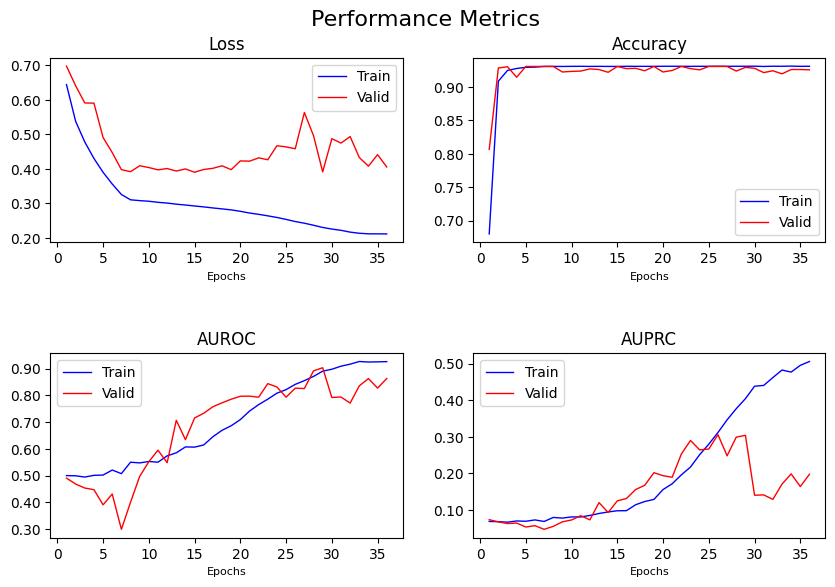

In [11]:
def plot_metric_subplot(train_metric, val_metric, metric_name, subplot_position):
    """
    서브플롯 위치에 성능 지표에 대한 그래프를 그립니다.
    :param train_metric: 훈련 데이터의 성능 지표
    :param val_metric: 검증 데이터의 성능 지표
    :param metric_name: 그래프에 표시할 성능 지표의 이름
    :param subplot_position: subplot의 위치 (예: 221, 222, 223, 224)
    """
    plt.subplot(subplot_position)
    epochs = range(1, len(train_metric) + 1)
    plt.plot(epochs, train_metric, 'b-', label='Train', lw=1)
    plt.plot(epochs, val_metric, 'r-', label='Valid', lw=1)
    plt.title(metric_name, fontsize=12)
    plt.xlabel('Epochs', fontsize=8)



    # Y축 눈금을 소수점 두 자리 형식으로 설정
    ax = plt.gca()
    y_vals = ax.get_yticks()
    ax.yaxis.set_major_locator(FixedLocator(y_vals))
    ax.set_yticklabels(['{:.2f}'.format(y) for y in y_vals])

    plt.legend()



# 성능 지표를 파일에서 불러오는 함수
def load_metrics(filename):
    with open(filename, 'r') as file:
        data = json.load(file)
        train_losses = [epoch_info['train_loss'] for epoch_info in data.values()]
        val_losses = [epoch_info['valid_loss'] for epoch_info in data.values()]
        train_accuracies = [epoch_info['train_accuracy'] for epoch_info in data.values()]
        val_accuracies = [epoch_info['valid_accuracy'] for epoch_info in data.values()]
        train_aurocs = [epoch_info['train_auroc'] for epoch_info in data.values()]
        val_aurocs = [epoch_info['valid_auroc'] for epoch_info in data.values()]
        train_auprcs = [epoch_info['train_auprc'] for epoch_info in data.values()]
        val_auprcs = [epoch_info['valid_auprc'] for epoch_info in data.values()]
        return train_losses, val_losses, train_accuracies, val_accuracies, train_aurocs, val_aurocs, train_auprcs, val_auprcs

# 파일에서 성능 지표를 불러옵니다.
train_losses, val_losses, train_accuracies, val_accuracies, train_aurocs, val_aurocs, train_auprcs, val_auprcs = load_metrics('model_info.json')



# 2x2 격자 형태로 그래프 그리기
plt.figure(figsize=(10, 6))  # 전체 그래프의 크기 설정
plt.suptitle('Performance Metrics', fontsize=16)

plot_metric_subplot(train_losses, val_losses, 'Loss', 221)
plot_metric_subplot(train_accuracies, val_accuracies, 'Accuracy', 222)
plot_metric_subplot(train_aurocs, val_aurocs, 'AUROC', 223)
plot_metric_subplot(train_auprcs, val_auprcs, 'AUPRC', 224)

plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.2, hspace=0.6)
plt.show()


# Test

In [15]:


# ROC 커브와 PRC 그리기
def plot_roc_and_prc(y_true, y_pred, data_name):
    # ROC 커브
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {data_name}')
    plt.legend(loc="lower right")

    # PRC
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, color='green', lw=2, label='PR curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve for {data_name}')
    plt.legend(loc="lower left")
    plt.show()

# Youden Index를 사용하여 최적의 임계값 찾기
def find_optimal_cutoff(y_true, y_pred):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    youden_index = tpr - fpr
    optimal_idx = np.argmax(youden_index)
    optimal_threshold = thresholds[optimal_idx]
    return optimal_threshold

# Confusion Matrix 시각화
def plot_confusion_matrix(y_true, y_pred, thresh, data_name):
    cm = confusion_matrix(y_true, y_pred > thresh)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {data_name}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()


def test_model(model, test_loader, data_name):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()
    criterion = nn.BCEWithLogitsLoss()

    test_loss, test_preds, test_targets = 0.0, [], []
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc=f"Testing {data_name}"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            test_loss += criterion(outputs.view(-1), labels.float()).item()
            test_preds.extend(torch.sigmoid(outputs).view(-1).cpu().detach().numpy())
            test_targets.extend(labels.cpu().numpy())

    optimal_threshold = find_optimal_cutoff(test_targets, test_preds)
    test_accuracy = accuracy_score(test_targets, np.array(test_preds) > optimal_threshold)
    test_loss /= len(test_loader)
    test_auroc = roc_auc_score(test_targets, test_preds)
    test_auprc = average_precision_score(test_targets, test_preds)

    print(f'[{data_name} Test] AUROC: {test_auroc:.4f} / AUPRC: {test_auprc:.4f} / Accuracy: {test_accuracy * 100:.2f}% / Loss: {test_loss:.4f}')
    plot_roc_and_prc(test_targets, test_preds, data_name)
    plot_confusion_matrix(test_targets, test_preds, optimal_threshold, data_name)


def test_datasets(model_class, model_filename):
    try:
        model = model_class()
        model.load_state_dict(torch.load(model_filename))

        # PTB 데이터셋 테스트
        _, _, ptb_test_loader = create_dataloaders()
        test_model(model, ptb_test_loader, "PTB")

        # SPH 데이터셋 테스트
        sph_test_loader = load_sph_data()
        test_model(model, sph_test_loader, "SPH")

    except Exception as e:
        print(f"Testing failed: {e}")

Testing PTB: 100%|██████████| 35/35 [00:00<00:00, 123.05it/s]


[PTB Test] AUROC: 0.9762 / AUPRC: 0.8437 / Accuracy: 96.74% / Loss: 0.0922


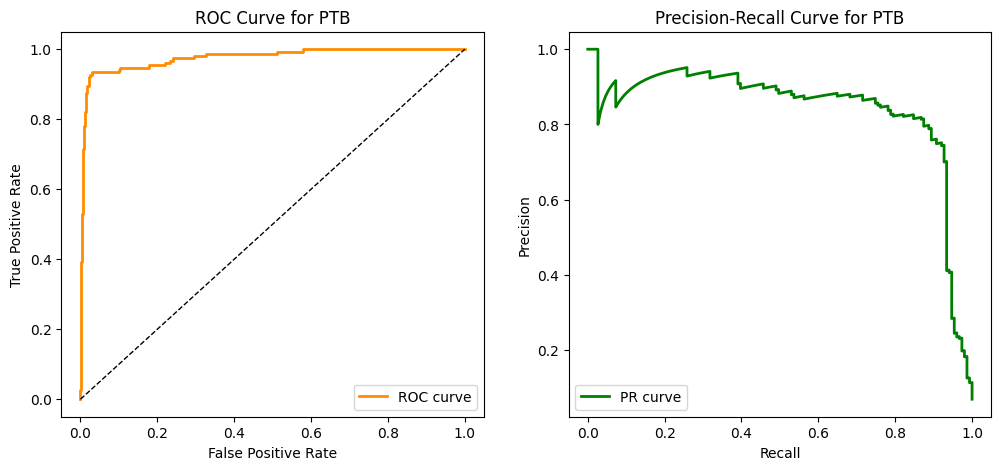

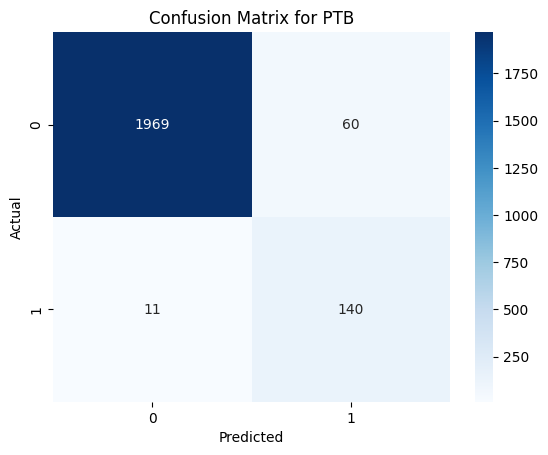

Testing SPH: 100%|██████████| 403/403 [00:03<00:00, 124.63it/s]


[SPH Test] AUROC: 0.9931 / AUPRC: 0.8255 / Accuracy: 97.62% / Loss: 0.0361


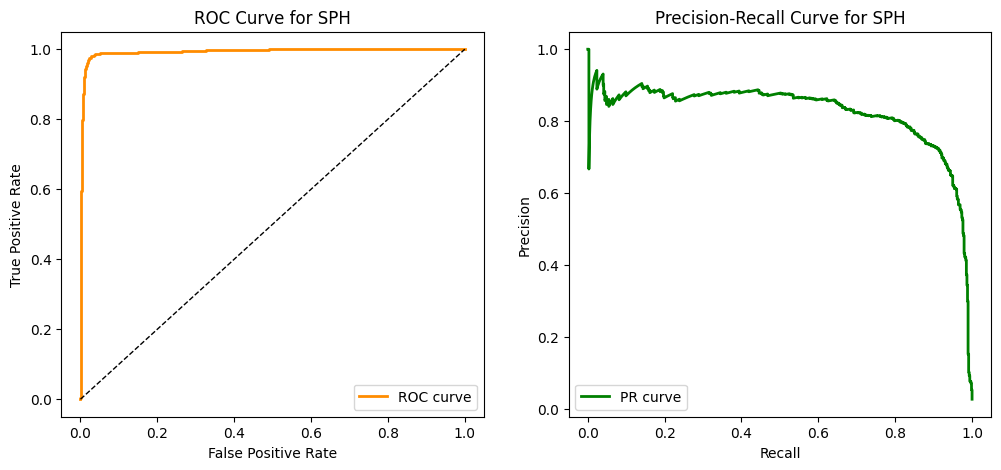

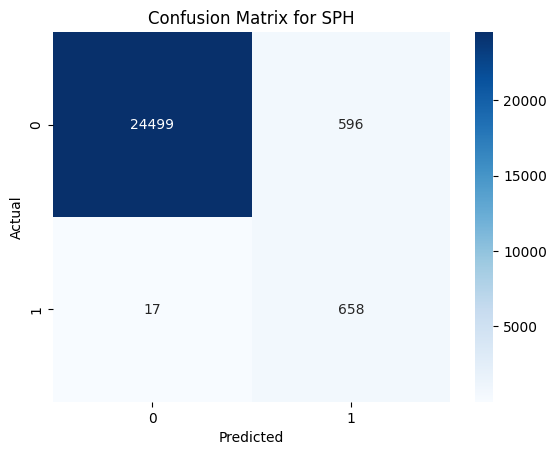

In [19]:
# 두 데이터셋을 함께 테스트
test_datasets(Custom1DCNN, 'trial_1_best_model.pth')